# À propos de ce livret


### Recherches associées
>Ruslan Salakhutdinov, Andriy Mnih (2008). **Probabilistic Matrix Factorization.**


### Codes sources
>[**Dépôt 1**](https://github.com/xinychen/transdim/blob/master/experiments/Imputation-PMF-Gdata.ipynb) *Version Python*  
>[**Dépôt 2**](https://github.com/xuChenSJTU/PMF)  |  *Version Python*  
>[**Dépôt 3**](https://github.com/stxupengyu/Probabilistic-Matrix-Factorization) *Version R*  
>[**Code original**](http://www.cs.toronto.edu/~rsalakhu/code_BPMF/pmf.m) *Version MATLAB*


### Notes supplémentaires
*Lien vers un [article](https://towardsdatascience.com/probabilistic-matrix-factorization-b7852244a321) qui explique le modèle en détail*  

Implémentations intéressantes: [**Implémentation**](https://github.com/kyrre/pmf/blob/master/pmf.py)  

## Préparation de l'environnement pour l'utilisation

In [178]:
# Utilités
import os
import numpy as np
from numpy import linalg as LA

# Chargement des données
import scipy.io

# Barre de progression
from tqdm.auto import trange
from tqdm import tqdm_notebook, notebook

# Présentation des résultats
import matplotlib.pyplot as plot
import matplotlib.cm as cm

In [179]:
dossier_travail = "C:/Users/amass/OneDrive/02_Education/02_Maitrise/Cours/PROJET_MAITRISE/application"
os.chdir(dossier_travail)

# Données

## Chargement des données

In [180]:
# Chargement du tenseur de données
tensor = scipy.io.loadmat('data/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']

# Chargement de la matrice aléatoire de données
random_matrix = scipy.io.loadmat('data/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

# Chargement du tenseur aléatoire de données
random_tensor = scipy.io.loadmat('data/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

print(
    "Tensor shape : {:} | Random matrix shape : {:} | Random tensor shape : {:}"
    .format(tensor.shape, random_matrix.shape, random_tensor.shape))

Tensor shape : (214, 61, 144) | Random matrix shape : (214, 61) | Random tensor shape : (214, 61, 144)


## Format des données

In [181]:
petit_donnees = True

# Paramètres du jeu de données tronqué
capteurs = 50
jours = 10
sequences = tensor.shape[2]

matrice = True

if petit_donnees == True:
    tensor = tensor[0:capteurs, 0:jours, 0:sequences]

    random_tensor = random_tensor[0:capteurs, 0:jours, 0:sequences]

print("The tensors shapes are : {:} | {:}".format(tensor.shape,
                                                  random_tensor.shape))

if matrice == True:
    dense_mat = tensor.reshape(
        [tensor.shape[0], tensor.shape[1] * tensor.shape[2]])

    print("The matrix shape is : {:}".format(dense_mat.shape))

The tensors shapes are : (50, 10, 144) | (50, 10, 144)
The matrix shape is : (50, 1440)


## Scénario de manquants

In [182]:
missing_rate = 0.4

random_missing = True

# Revoir le code pour que les deux choix puissent être respectés sur l'ensemble des matrices/ tenseurs
if random_missing == True:
    print("Random missing (RM) scenario")
    binary_mat = (np.round(random_tensor + 0.5 - missing_rate).reshape([
        random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]
    ]))
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))
else:
    print("Non-random missing (NM) scenario")
    binary_tensor = np.zeros(tensor.shape)
    for i1 in range(tensor.shape[0]):
        for i2 in range(tensor.shape[1]):
            binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 -
                                                missing_rate)
    binary_mat = binary_tensor.reshape([
        binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]
    ])
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))

sparse_mat = np.multiply(dense_mat, binary_mat)

Random missing (RM) scenario

Binary matrix shape : (50, 1440)


In [183]:
# Données pour l'entrainement
train_data = np.zeros((sparse_mat[sparse_mat > 0].shape[0], 3))

start_idx = 0

for i in range(sparse_mat.shape[0]):
    for t in range(sparse_mat.shape[1]):
        if sparse_mat[i, t] > 0:
            train_data[start_idx, 0] = i + 1  # User ID
            train_data[start_idx, 1] = t + 1  # Product ID
            train_data[start_idx, 2] = sparse_mat[i, t]  # Rating
            start_idx += 1

# Données pour la validation
validation_mat = dense_mat

validation_mat[sparse_mat > 0] = 0

test_data = np.zeros((validation_mat[validation_mat > 0].shape[0], 3))

start_idx = 0
for i in range(validation_mat.shape[0]):
    for t in range(validation_mat.shape[1]):
        if validation_mat[i, t] > 0:
            test_data[start_idx, 0] = i + 1  # User ID
            test_data[start_idx, 1] = t + 1  # Product ID
            test_data[start_idx, 2] = validation_mat[i, t]  # Rating
            start_idx += 1

# Modélisation

## Spécification du modèle

Dans la recherche, ils spécifient que : 
>« Suppose we have M movies, N users, and integer rating values from 1 to K1. Let Rij represent the rating of user i for movie j, U ∈ RD×N and V ∈ RD×M be latent user and movie feature matrices, with column vectors Ui and Vj representing user-specific and movie-specific latent feature vectors respectively. »

In [264]:
import numpy as np
from numpy import linalg as LA


def pmf(train_data,
        val_data,
        rang=10,
        epsilon=0.05,
        _lambda=0.1,
        momentum=0.8,
        maxepoch=1000,
        num_batches=50,
        batch_size=500):
    """
    
    
    
    
    
    """

    # Initialisation de l'entrainement
    train_rmse_liste = []
    test_rmse_liste = []

    # mean subtraction (normalisation ?)
    mean_U = np.mean(train_data[:, 2])

    # 1-p-i, 2-m-c
    dim1 = int(max(np.amax(train_data[:, 0]), np.amax(val_data[:, 0]))) # + 1  Enlève le + 1 (parce que le U et V n'était pas de la bonne grandeur)
    dim2 = int(max(np.amax(train_data[:, 1]), np.amax(val_data[:, 1]))) # + 1  Enlève le + 1 (parce que le U et V n'était pas de la bonne grandeur)

    incremental = False  # ?
    if ((not incremental) or (V is None)):
        # initialize
        epoch = 0
        np.random.seed(2020) # Reproductibilité
        V = 0.1 * np.random.randn(dim2, rang) 
        np.random.seed(2020) # Reproductibilité
        U = 0.1 * np.random.randn(dim1, rang) 

        V_inc = np.zeros((dim2, rang))  # Matrice à incrémenter
        U_inc = np.zeros((dim1, rang))  # Matrice à incrémenter

    for epoch in notebook.tqdm(list(range(maxepoch)),
                               desc="Itérations", leave = False):  #while epoch < maxepoch:
        epoch += 1

        # Shuffle training truples
        shuffled_order = np.arange(train_data.shape[0])
        np.random.shuffle(shuffled_order)

        # Batch update
        for batch in notebook.tqdm(list(range(num_batches)), desc="Batch", leave = False):
            # print("epoch %d batch %d" % (epoch, batch+1))
            batch_idx = np.mod(
                np.arange(batch_size * batch, batch_size * (batch + 1)),
                shuffled_order.shape[0])

            batch_UID = np.array(train_data[shuffled_order[batch_idx], 0],
                                   dtype='int32')
            batch_VID = np.array(train_data[shuffled_order[batch_idx], 1],
                                   dtype='int32')

            # Compute Objective Function
            
            pred_out = np.sum(np.multiply(U[batch_UID - 1, :], 
                                          V[batch_VID - 1, :]),
                              axis=1)  # mean_U subtracted, enlève 1 pour les indexes

            rawErr = pred_out - train_data[shuffled_order[batch_idx],
                                          2] + mean_U

            # Compute gradients
            # U
            Ix_V = 2 * np.multiply(rawErr[:, np.newaxis], U[
                batch_UID-1, :]) + _lambda * V[batch_VID-1, :]
            # V
            Ix_U = 2 * np.multiply(rawErr[:, np.newaxis], V[
                batch_VID-1, :]) + _lambda * U[batch_UID-1, :]

            dV = np.zeros((dim2, rang))
            dU = np.zeros((dim1, rang))

            # loop to aggreate the gradients of the same element
            for i in notebook.tqdm(list(range(batch_size)),
                                   desc="Agg. gradients / batch", leave = False):
                
                dV[batch_VID[i]-1, :] += Ix_V[i, :]
                dU[batch_UID[i]-1, :] += Ix_U[i, :]

            # Update with momentum
            V_inc = momentum * V_inc + epsilon * dV / batch_size
            U_inc = momentum * U_inc + epsilon * dU / batch_size

            V = V - V_inc  # U
            U = U - U_inc  # V

        # Compute train error
        train_out = np.sum(np.multiply(
            U[np.array(train_data[:, 0], 
                         dtype='int32') -1, :] ,
            V[np.array(train_data[:, 1],
                         dtype='int32') - 1, :] ),
                           axis=1)
        error_train = train_out - train_data[:, 2] + mean_U
        train_rmse = LA.norm(error_train) / np.sqrt(len(train_data))

        train_rmse_liste.append(train_rmse)

        # Compute validation error
        test_out = np.sum(np.multiply(
            U[np.array(val_data[:, 0]-1, dtype='int32'), :],
            V[np.array(val_data[:, 1]-1, dtype='int32'), :]),
                          axis=1)
        error_test = test_out - val_data[:, 2] + mean_U
        test_rmse = LA.norm(error_test) / np.sqrt(len(val_data))

        test_rmse_liste.append(test_rmse)
        
        # Arrêt si la validation ne descend plus
        if epoch > 1:
            previous = test_rmse_liste[len(test_rmse_liste) - 2]
            if test_rmse > previous:
                print("Validation a arrêtée de diminuer. RMSE final: {:}".format(previous))
                break
                

        if epoch % 50 == 0:
            # Print information
            print(('%f th epoch, train RMSE: %f, test RMSE: %f' %
                   (epoch, train_rmse, test_rmse)))


    return V, U, train_rmse_liste, test_rmse_liste, test_rmse



In [ ]:
rang = list(range(1, 30, 5))
txa = list(range(1, 10, 5))  # diviser par 10
reg = list(range(1, 10, 5))  # Diviser par 10
mom = list(range(1, 10, 5))  # diviser par 10
epoch = 100

liste_entrainement = list()

for r in notebook.tqdm(rang, leave = True):
    for a in notebook.tqdm(txa, leave = True):
        for tr in notebook.tqdm(reg, leave = True):
            for m in notebook.tqdm(mom, leave = True):
                print(("Hyperparamètres : {:}, {:}, {:}, {:}".format(r, a, tr, m)))
                V, U, train_rmse_liste, test_rmse_liste, test_rmse = pmf(
                    train_data=train_data,
                    val_data=test_data,
                    rang=r,
                    epsilon=a / 10,
                    _lambda=tr / 10,
                    momentum=m / 10,
                    maxepoch=epoch,
                    num_batches=50,
                    batch_size=500)
                hyper = "Hyperparamètres : {:}, {:}, {:}, {:}".format(r, a, tr, m)
                
                liste_entrainement.append([test_rmse, hyper])

Hyperparamètres : 1, 1, 1, 1


Validation a arrêtée de diminuer
Hyperparamètres : 1, 1, 1, 6


Validation a arrêtée de diminuer



Hyperparamètres : 1, 1, 6, 1


Validation a arrêtée de diminuer
Hyperparamètres : 1, 1, 6, 6


Validation a arrêtée de diminuer




Hyperparamètres : 1, 6, 1, 1


Validation a arrêtée de diminuer
Hyperparamètres : 1, 6, 6, 6


Validation a arrêtée de diminuer





Hyperparamètres : 6, 1, 1, 1


Validation a arrêtée de diminuer
Hyperparamètres : 6, 1, 1, 6


Validation a arrêtée de diminuer



Hyperparamètres : 6, 1, 6, 1


Validation a arrêtée de diminuer
Hyperparamètres : 6, 1, 6, 6


50.000000 th epoch, train RMSE: 4.179137, test RMSE: 4.668288


Validation a arrêtée de diminuer
Hyperparamètres : 6, 6, 1, 6


Validation a arrêtée de diminuer



Hyperparamètres : 6, 6, 6, 1


Validation a arrêtée de diminuer
Hyperparamètres : 6, 6, 6, 6


Validation a arrêtée de diminuer





Hyperparamètres : 11, 1, 1, 1


50.000000 th epoch, train RMSE: 4.382680, test RMSE: 4.849170


Validation a arrêtée de diminuer
Hyperparamètres : 11, 1, 1, 6


Validation a arrêtée de diminuer



Hyperparamètres : 11, 1, 6, 1


Exception ignored in: 

## Entrainement du modèle

- Peaufinement d'hyperparamètres

# Présentation des résultats

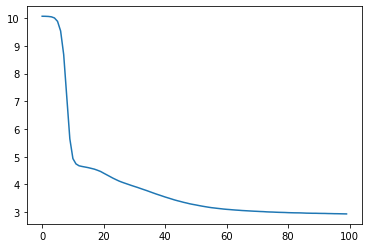

In [10]:
plot.plot(train_rmse_liste)

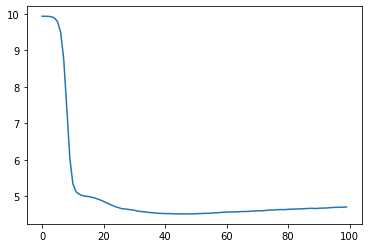

In [11]:
plot.plot(test_rmse_list)